In [10]:
# imports
%matplotlib inline   
                     # this sets up matplotlib to make plots show up in the notebook
import numpy as np   # imports the numpy package, abbreviated as np
import matplotlib    # imports the matplotlib package for making plots
import matplotlib.pyplot as plt    # imports the part of matplotlib we use most,
 
import scipy.stats as stats
import astropy.stats as astats
import numpy.random as random
from astropy.table import Table
import pandas as pd

# Continuing from before: Fitting for the Hubble constant with supernovae

We are continuing to work with the Hicken et al. ("Consitution") supernova dataset.  First, we read in the file into a table named `data`:

In [11]:
# CHANGE THE BELOW LINE TO POINT TO THE DIRECTORY CONTAINING SNDATA.TXT
path = './'  

# the astropy way
#data=Table.read(path+'sndata.txt',format='ascii')

# the pandas way: the file is in "fixed-width format" so we use read_fwf
data=pd.read_fwf(path+'sndata.txt')

cz=data['cz']
mu=data['mu']
sigma_mu=data['sigma_mu']

weight=1/sigma_mu**2
d = 10**(mu/5)*1E-5

logv=np.log10(cz)

# Regression with scikit-learn

We'll start using scikit-learn for a case we've already looked at: simple linear regression.  We'll find that msny algorithms can be run with a similar interface, though.  (Note: some robust regression techniques are also available; check out the documentation on RANSAC and Huber Regression at http://scikit-learn.org/stable/modules/linear_model.html).  Also see  http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model for detailed documentation about these routines).

[5.05398642] 15.777002990436124
slope: 5.054
intercept: 15.777
H0: 69.920 km/sec/Mpc


/var/folders/9j/njs_shy50c3847zl8765jn3m0000gn/T/ipykernel_55442/3291283145.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  Xsl=(logv.ravel() ).reshape(len(logv),1)


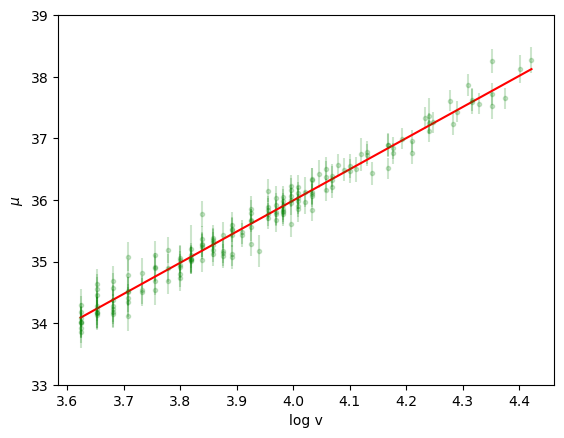

In [26]:
import sklearn

import sklearn.linear_model as lm

# fit for mu as a function of logv, with weights of 1/sigma_mu^2

# X variable needs to be an (nsamples x nfeatures) array: 
# need to reshape logv to an Nx1 array instead of just an N-element array
#X=logv.reshape(len(logv),1)
Xsl=(logv.ravel() ).reshape(len(logv),1)

# create simple regression model object
simple_model = lm.LinearRegression()

# fit the model
simple_model.fit(Xsl,mu, weight)

# print out the slope & intercept from the model.  Note that coef_ is an array, but we
# only have one feature so it has one element.
print(simple_model.coef_, simple_model.intercept_)

if 1:
    print(f'slope: {simple_model.coef_[0]:.3f}')
    print(f'intercept: {simple_model.intercept_:.3f}')
    print(f'H0: {(10**(-0.2*simple_model.intercept_-np.log10(1E-5))):.3f} km/sec/Mpc')
# we can make points semi-transparent by setting alpha < 1
    plt.errorbar(logv,mu,yerr=sigma_mu,fmt='g.',alpha=0.2)
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
    
    
# to get predictions from our model for arbitrary new data, we just use the .predict() method.
# note that we still need an Nx1 array rather than a simple N-element array.
    plt.plot(logv,simple_model.predict(Xsl),'r-')

## Dealing with overfitting: Ridge Regression, LASSO, and Elastic Net

Scikit-learn provides a number of variants of linear regression that minimize different losses (not just chi-squared) in such a way that we are less likely to get multiple nearly-cancelling coefficients as part of our fit, which may fit our particular dataset well but will extrapolate poorly.

We can explore this by trying to fit quartic functions again, with these regression variants.

[-273.2695196   109.00442568  -18.94667959    1.23304664] 281.9221303463516
slope: -273.270
intercept: 281.922
H0: 0.000 km/sec/Mpc


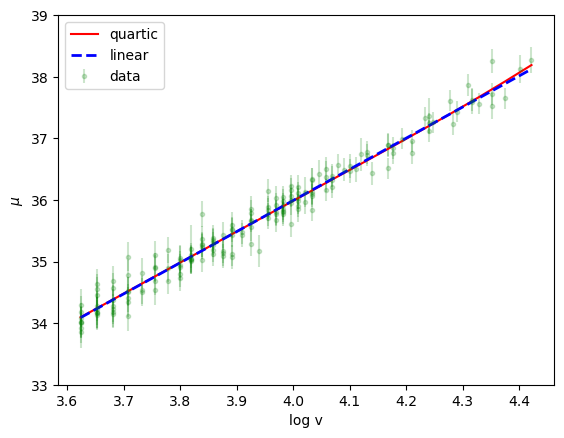

In [25]:
# Make an X array containing logv, logv^2, logv^3, and logv^4:
X_quart = np.stack([logv,logv**2,logv**3,logv**4],axis=1)

# initialize quartic model
quart_model = lm.LinearRegression()

# fit the model
quart_model.fit(X_quart,mu, weight)

# print out the coefficients & intercept from the model.  
print(quart_model.coef_, quart_model.intercept_ )

if 1:
    print(f'slope: {quart_model.coef_[0]:.3f}')
    print(f'intercept: {quart_model.intercept_:.3f}')
    print(f'H0: {(10**(-0.2*quart_model.intercept_-np.log10(1E-5))):.3f} km/sec/Mpc')

    plt.errorbar(logv,mu,yerr=sigma_mu,fmt='g.',alpha=0.2,label='data')
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
# lw keyword sets line thickness 
    plt.plot(logv,quart_model.predict(X_quart),'r-',label='quartic',lw=1.5)
    plt.plot(logv,simple_model.predict(Xsl),'b--', label='linear',lw=2)
    plt.legend(loc='best')

## Ridge regression

Ridge regression adds robustness to overfitting due to covariant features by minimizing, not the sum of the squares of the residuals, but that quantity __PLUS the sum of the squares of all the coefficients from the fit (their "L2 norm").__  To put all the features on the same rough scale, we will remap all features to have mean 0 and variance 1 (otherwise some features effectively get penalized more than others).  Nominally the `normalize=True` keyword should accomplish this, but it didn't work as well for me as explicitly rescaling for some reason...  

Techniques for reducing overfitting are generally referred to as 'regularization' methods.  By reducing overfitting, we reduce the variance we'd get from our fit when applied to data outside its training set, at the cost of potentially having a somewhat biased estimator (as we no longer are using an 'optimal', Maximum Likelihood-based least-squares method).

__In the below code box, change the value of alpha and observe how the coefficients (especially for the higher-order terms) change.__  Alpha=0 corresponds to ordinary regression.  Try a number of values ranging from minuscule values (e.g. 1E-6) to 100.  Can you explain the behavior?

[ 0.615982    0.35853476  0.12382853 -0.08654236] 35.6601695106628
slope: 0.616
intercept: 35.660


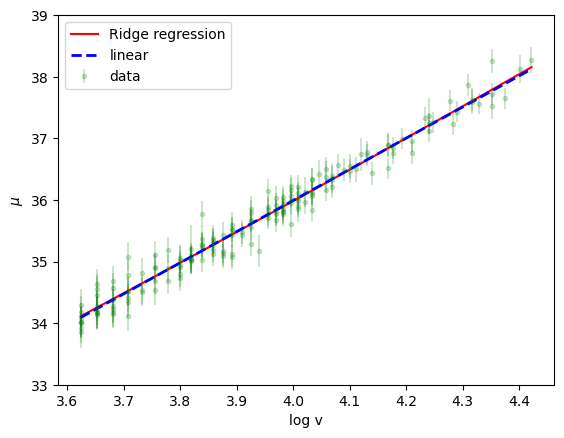

In [24]:
# initialize ridge regression model.  The alpha parameter controls how strongly we penalize coefficient values.
# 
ridge_model = lm.Ridge(alpha=1)

# We need to normalize variables to have mean 0 and variance 1 before fitting.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# even the rescaling requires a fit step...
scaler.fit(X_quart)  
# then we apply the scalar to create a new array of features
X_quart_norm = scaler.transform(X_quart)

# Note: We could have used the .fit_transform() method to fit + transform in one step

# fit the model
ridge_model.fit(X_quart_norm, mu, weight)

# print out the coefficients & intercept from the model.  
print(ridge_model.coef_, ridge_model.intercept_ )

# Note: because we rescaled the X array, we don't expect slope=5 any more

if 1:
    print(f'slope: {ridge_model.coef_[0]:.3f}')
    print(f'intercept: {ridge_model.intercept_:.3f}')

    plt.errorbar(logv,mu,yerr=sigma_mu,fmt='g.',alpha=0.2, label='data')
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
    plt.plot(logv,ridge_model.predict(X_quart_norm),'r-',label='Ridge regression',lw=1.5)
    plt.plot(logv,simple_model.predict(Xsl),'b--',label='linear',lw=2)
    plt.legend(loc='best')

## LASSO

The LASSO algorithm penalizes the sum of the __absolute values__ of the coefficients (the "L1 norm"),  rather than the sum of the squares.  This tends to drive coefficients all the way to zero -- i.e., eliminating features from the fit. 

The `alpha` parameter determines how large the penalty for nonzero values is.  __In the below code box, change the value of alpha over several orders of magnitude and observe how the coefficients (especially for the higher-order terms) and fit quality change.__  Alpha=0 corresponds to ordinary regression.

`Scikit-learn` also implements ElasticNet in `lm.ElasticNet`; this combines an L2-based penalty like Ridge with an L1-based penalty like LASSO.  It works the same way as `lm.Lasso` except with an extra parameter to determine how much weight to give to L2 vs. L1.

[0.86087538 0.04906029 0.04709345 0.04505187] 35.66173806354799
slope: 0.861
intercept: 35.662


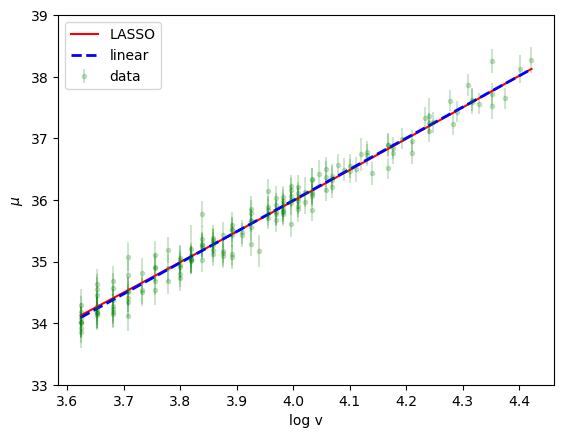

In [23]:
# initialize LASSO model.  
# The alpha parameter controls how strongly we penalize for nonzero values of coefficients.  
lasso_model = lm.Lasso(alpha=1E-2)

# fit the model
lasso_model.fit(X_quart_norm,mu, sample_weight=weight)

# print out the coefficients & intercept from the model.  
print(lasso_model.coef_, lasso_model.intercept_)

if 1:
    print(f'slope: {lasso_model.coef_[0]:.3f}')
    print(f'intercept: {lasso_model.intercept_:.3f}')

    plt.errorbar(logv,mu,yerr=sigma_mu,fmt='g.',alpha=0.2,label='data')
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
    plt.plot(logv,lasso_model.predict(X_quart_norm),'r-',label='LASSO',lw=1.5)
    plt.plot(logv,simple_model.predict(Xsl),'b--',label='linear',lw=2)
    plt.legend(loc='best')

## Probably optional: SGDRegressor

Another routine, `lm.SGDRegressor`, can handle robust regression, ridge regression, LASSO and ElasticNet all in one.

 __In the below code box, change the value of alpha over several orders of magnitude and observe how the coefficients (especially for the higher-order terms) and fit quality change.__  See if you can find an alpha parameter that yields a pure-linear fit.


[0.61829311 0.33778094 0.05162809 0.        ] [35.66143941]
slope: 0.618
intercept: 35.661


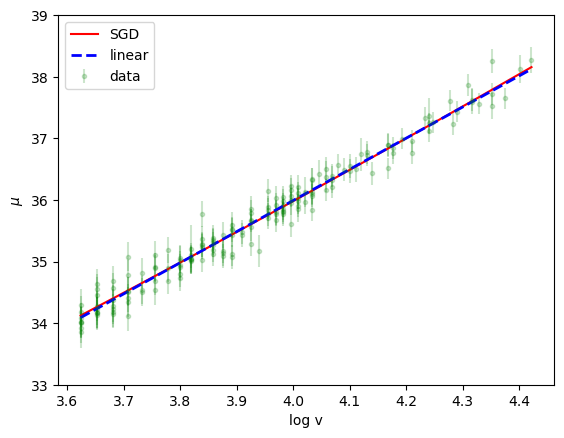

In [22]:
# initialize SGD model.  
#The alpha parameter controls how strongly we penalize for 
#     nonzero values of coefficients.  
#  We'll use the Huber t robust regression loss, and an L1 penalty ==LASSO ). 

# Set verbose=True if you want to see diagnostic output.

# The tol parameter sets how small a change in loss per iteration to define as convergence
sgd_model = lm.SGDRegressor(loss='huber',penalty='l1',alpha=1E-2,verbose=False, tol=1E-6)

# fit the model.  
sgd_model.fit(X_quart_norm, mu,sample_weight=weight)

# print out the coefficients & intercept from the model.  
print(sgd_model.coef_, sgd_model.intercept_ )

if 1:
    print(f'slope: {sgd_model.coef_[0]:.3f}')
    print(f'intercept: {sgd_model.intercept_[0]:.3f}')

    plt.errorbar(logv,mu,yerr=sigma_mu,fmt='g.',alpha=0.2,label='data')
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
    plt.plot(logv,sgd_model.predict(X_quart_norm),'r-',label='SGD',lw=1.5)
    plt.plot(logv,simple_model.predict(Xsl),'b--',label='linear',lw=2)
    plt.legend(loc='best')

# Optimizing the alpha parameter

As we increase alpha, we are trading off increasing the potential bias of our estimated coefficients with reducing the variance of predictions outside our dataset.  We can assess the net effect by fitting our model to one subset of the data, and testing with another.

__Run the code in the below box multiple times and see how the plot changes.__


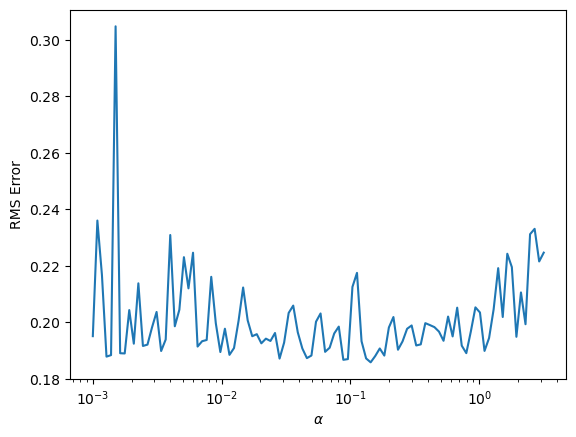

In [20]:
from sklearn.model_selection import train_test_split

# To better assess the quality of the fitting, 
# we randomly split the data into Training (50%) and Test (50%) sets. 
# The code below performs this task on the X_quart_norm, mu, 
#   and sigma_mu arrays:

X_train, X_test, mu_train, mu_test, weight_train, weight_test = \
            train_test_split(X_quart_norm, mu, weight, \
            test_size = 0.5, train_size = 0.5)

from sklearn.metrics import mean_squared_error

# create an array of test values of alpha, from 1E-4 to 10**0.5, 
#     logarithmically spaced
alpha_test = np.logspace(-3,0.5,100)
mse=alpha_test*0.

#for each test value of alpha, evaluate the mean squared error 
#    from the regression fit, using the test set only

for i,a in enumerate(alpha_test):
    sgd_model = lm.SGDRegressor(loss='squared_error',penalty='l1', \
                                alpha=a,tol=1E-7,verbose=False)

# fit the model.  
    sgd_model.fit(X_train,mu_train,sample_weight=weight_train)
# Calculate the weighted mean square error (MSE)
    mse[i]=mean_squared_error(mu_test,sgd_model.predict(X_test), \
                              sample_weight=weight_test)
    
# Note: RMS error is square root of MSE    
    
if 1:
    plt.semilogx(alpha_test,np.sqrt(mse))
    plt.ylabel('RMS Error')
    plt.xlabel(r'$\alpha$')

## Cross-validation

With a 50-50 training/testing split, we are always training significantly more poorly than we would with the full dataset, and can only use half the data to evaluate how well we are doing.  K-fold cross-validation provides a way around this.  

In k-fold cross-validation, we split the data into k subsets.  We loop over the subsets, training with all but one and testing with the other; in the end, we get the performance of training with a fraction $k-1 \over k$ of the data, but are able to get test statistics based on the __entire__ dataset.

This is easy to do in scikit-learn, but does mean running the training k times on more data than before...so slows things down a lot.

(Note: we can search multi-dimensional grids of parameters in a more automated way with `sklearn.model_selection.GridSearchCV`; see http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html for an example).

__Based on your results, what value of alpha would you choose for this problem?  Discuss with your neighbors.__

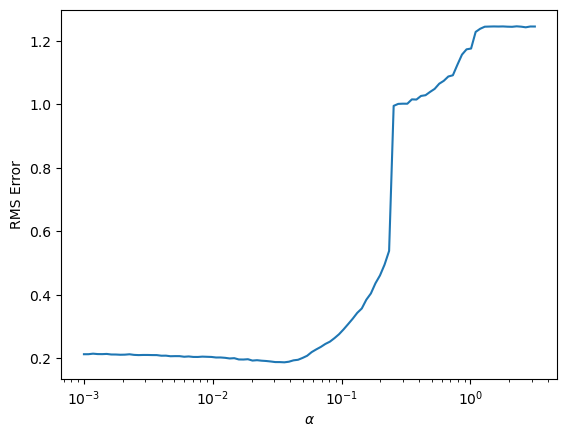

In [18]:
# cross_val_predict will do training and prediction for a scikit-learn object,
#   rotating the dataset between training and prediction via cross-validation

from sklearn.model_selection import cross_val_predict

mse=np.copy(alpha_test)*0.

for i,a in enumerate(alpha_test):
    # define the model object with our choice of alpha
    sgd_model = lm.SGDRegressor(loss='squared_error',penalty='l1',
                        alpha=a,tol=1E-5,verbose=False)
    # do training AND prediction on the whole sample using cross-validation
    predicted = cross_val_predict(sgd_model,X_quart_norm,mu, cv=5)
    #calculate mean squared error
    mse[i]=mean_squared_error(mu,predicted,sample_weight=weight)
        
# Note: RMS error is square root of MSE    
    
if 1:
    plt.semilogx(alpha_test,np.sqrt(mse))
    plt.ylabel('RMS Error')
    plt.xlabel(r'$\alpha$')

    

best alpha: 0.143
[0.55512958 0.34212023 0.12262688 0.        ] [35.65636665]
slope: 0.555
intercept: 35.656


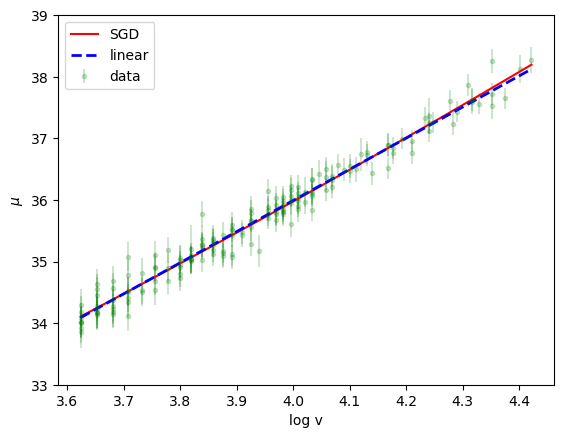

In [21]:
# let's do the fit with the alpha value that minimized mean squared error

whbest = mse.argmin()
print(f'best alpha: {alpha_test[whbest]:.3f}')


# note: with mean squared error loss (instead of Huber loss) the fit turns out to be unstable
sgd_model = lm.SGDRegressor(loss='huber',penalty='l1',\
                            alpha=alpha_test[whbest],verbose=False, tol=1E-7)


X_quart_norm = scaler.transform(X_quart)

# fit the model.  Syntax for weights is a little different from before, unfortunately...
sgd_model.fit(X_quart_norm, mu,sample_weight=weight)

# print out the coefficients & intercept from the model.  
print(sgd_model.coef_, sgd_model.intercept_ )

if 1:
    print(f'slope: {sgd_model.coef_[0]:.3f}')
    print(f'intercept: {sgd_model.intercept_[0]:.3f}')
    intercept = sgd_model.intercept_[0]

    plt.errorbar(logv,mu,yerr=sigma_mu,fmt='g.',alpha=0.2,label='data')
    plt.ylim(33,39)
    plt.xlabel('log v')
    plt.ylabel(r'$\mu$')
    plt.plot(logv,sgd_model.predict(X_quart_norm),'r-',label='SGD',lw=1.5)
    plt.plot(logv,simple_model.predict(Xsl),'b--',label='linear',lw=2)
    plt.legend(loc='best')

__For the optimal value of alpha, how many/which coefficients are being set to 0?__